## Gridsearch, Pipelines, and Column Transformer

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)

In this notebook, we will see how different preprocessing and computation steps can be combined into a pipeline, how data can be preprocessed using the column transformer and how the best hyperparameters for the algorithm can be searched for without using test data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn 
print(sklearn.__version__)

1.2.2


In [3]:
titanic = pd.read_csv("data/titanic.csv") # We return to our original version
titanic.shape

(891, 12)

In [4]:
titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
304,305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.050,NaN,S
582,583,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.000,NaN,S
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.650,E67,S
700,701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C
276,277,0,3,"Lindblom, Miss. Augusta Charlotta",female,45.0,0,0,347073,7.750,NaN,S


### 1. Data Analysis and Preprocessing

See previous notebooks as well

In [6]:
titanic.duplicated().sum()

0

In [7]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
titanic.dropna(subset=['Embarked'], inplace=True) # we drop rows with missing Embarked
# we will interpolate missing Age info and remove Cabin later

### 2. Set Up Train and Test Partitions


In [10]:
# Let's define our X and y
y = titanic.Survived
X = titanic.drop(columns=['Survived']) 
X.shape, y.shape # Dataframe and Series, respectively

((889, 11), (889,))

In [11]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((711, 11), (178, 11), (711,), (178,))

#### OneHotEncoder

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  

The one hot encoder allows us to transform nominal (unordered) features into binary ones by creating a feature for each value. It makes sense to do this because we don't want to include bias in our data. For example, the ```embarked``` feature has three values. We could make them 1, 2 and 3, for S, C, and Q, respectively. However, that would incorporate an unwanted bias that S and C are more similar somehow than S and Q. Embarked is not an ordinal feature so we should not use ordinal values.

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
ohe = OneHotEncoder()

In [17]:
ex = ohe.fit_transform(X_train[['Sex', 'Embarked']])
# we can do more than one feature at the same time

In [18]:
ex.todense()

matrix([[1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        ...,
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.]])

In [19]:
ohe.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [20]:
ohe.feature_names_in_

array(['Sex', 'Embarked'], dtype=object)

In [21]:
ohe.get_feature_names_out()

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype=object)

#### Ordinal Encoder

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html  

There is also an OrdinalEncoder.
For example when we have "small" "average" "big" as values for a feature, this is an ordinal feature: big is less similar to small than to average. After transformation with the OrdinalEncoder, the values will be 1, 2, 3.

#### Column Transformer

https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html  

The Column Transformer interfaces dataframes to sklearn. It applies different transformations to different columns of a dataframe (with different data types: numerical, nominal, ordinal, textual, etc.) and is very powerful in combination with pipelines. You can apply different preprocessing and feature extraction pipelines to different subsets of features: for example, normalizing numerical data, and vectorizing textual data, all within a single column transformer. When fit to a dataset, each transformer applies its transformation and the resulting outputs are concatenated into a single feature space. It also allows to pass through columns untransformed or drop them.

The ColumnTransformer takes a list of tuples specifying each transformation, with the syntax (transformer, columns). Each tuple includes the transformer (like StandardScaler or OneHotEncoder), and the columns to apply it to.

In [24]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (ohe, ['Embarked', 'Sex']),  # apply one hot encoding to embarked and sex
    ('passthrough', ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']), # just copy these through
    remainder='drop') # and don't keep the others

ct

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['Embarked', 'Sex']),
                                ('passthrough', 'passthrough',
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])])

In [25]:
print(ct)

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 ['Embarked', 'Sex']),
                                ('passthrough', 'passthrough',
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])])


In [26]:
# Note: Cabin is dropped by this as well

data = ct.fit_transform(X_train)
data[0]

array([  0.  ,   0.  ,   1.  ,   1.  ,   0.  ,   1.  ,  22.  ,   0.  ,
         0.  , 151.55])

In [27]:
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(711, 10)


In [28]:
ct.get_feature_names_out()

array(['onehotencoder__Embarked_C', 'onehotencoder__Embarked_Q',
       'onehotencoder__Embarked_S', 'onehotencoder__Sex_female',
       'onehotencoder__Sex_male', 'passthrough__Pclass',
       'passthrough__Age', 'passthrough__SibSp', 'passthrough__Parch',
       'passthrough__Fare'], dtype=object)

In [29]:
ct.named_transformers_

{'onehotencoder': OneHotEncoder(),
 'passthrough': 'passthrough',
 'remainder': 'drop'}

### 3. Model Construction: Pipelines

For the experiment we need to **scale** the numeric features and **impute** missing values and then **apply** logistic regression. An efficient way of combining these tasks in a transparant approach is to use the sklearn pipelines.

Pipelines provide a way to chain different tasks in sklearn together, where each step takes as input the output of the previous step and delivers output to the next step. There are two types of objects to perform tasks: estimators and transformers.

- An sklearn **estimator** is an object that learns from data (for example classification with logistic regression). It has a .fit(X,y) and a .predict(X)

- An sklearn **transformer** (not to be confused with the deep learning algorithm with that name) is an object that transforms a dataset into a new one, e.g., scaling numeric values, imputing missing values. It has a .fit(X) and a .transform(X) (that can be combined in .fit_transform(X)

Pipelines are ideal for making sure that exactly the same steps are taken in training and testing and that these two are kept separate (helps avoid test data leakage and other methodological problems).

Pipelines can be fit just like other sklearn objects and if they end in an estimator, they also have a .predict(X).

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  

In [33]:
# Now we combine everything into one architecture that we apply to both train and test

ohe = OneHotEncoder()
imputer = KNNImputer() # create a knn imputer
scaler = StandardScaler() # create a scaler

logreg = LogisticRegression(random_state=42) 

# Numeric features will be imputed and then scaled
numeric_preprocessing = make_pipeline (imputer, scaler)

# Categorical features will be encoded numerically
categorical_preprocessing = make_pipeline (ohe)

preprocessor = make_column_transformer(
    (numeric_preprocessing, ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
    (categorical_preprocessing, ['Sex', 'Embarked']),
    remainder='drop')

pipe = make_pipeline (preprocessor, logreg)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'Pclass']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Embarked'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [34]:
pipe.steps

[('columntransformer',
  ColumnTransformer(transformers=[('pipeline-1',
                                   Pipeline(steps=[('knnimputer', KNNImputer()),
                                                   ('standardscaler',
                                                    StandardScaler())]),
                                   ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
                                  ('pipeline-2',
                                   Pipeline(steps=[('onehotencoder',
                                                    OneHotEncoder())]),
                                   ['Sex', 'Embarked'])])),
 ('logisticregression', LogisticRegression(random_state=42))]

In [35]:
pipe[0].get_feature_names_out()

array(['pipeline-1__Age', 'pipeline-1__SibSp', 'pipeline-1__Parch',
       'pipeline-1__Fare', 'pipeline-1__Pclass', 'pipeline-2__Sex_female',
       'pipeline-2__Sex_male', 'pipeline-2__Embarked_C',
       'pipeline-2__Embarked_Q', 'pipeline-2__Embarked_S'], dtype=object)

In [36]:
pipe[1].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### 4. Model Evaluation

In [38]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [39]:
X_test_predictions = pipe.predict(X_test)
X_test_predictions

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1])

In [40]:
print(classification_report(y_test, X_test_predictions))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       109
           1       0.72      0.78      0.75        69

    accuracy                           0.80       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178



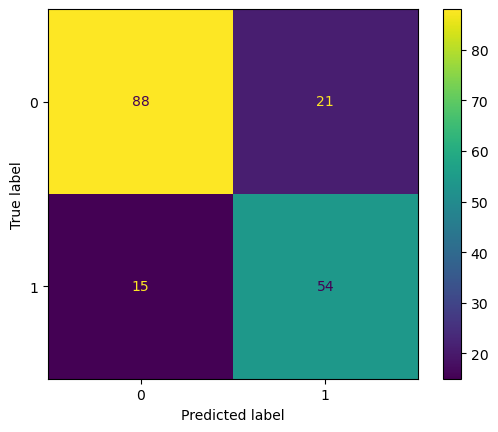

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, X_test_predictions);

In [42]:
pipe[0].get_feature_names_out()

array(['pipeline-1__Age', 'pipeline-1__SibSp', 'pipeline-1__Parch',
       'pipeline-1__Fare', 'pipeline-1__Pclass', 'pipeline-2__Sex_female',
       'pipeline-2__Sex_male', 'pipeline-2__Embarked_C',
       'pipeline-2__Embarked_Q', 'pipeline-2__Embarked_S'], dtype=object)

In [43]:
pipe[1].intercept_

array([-0.01283108])

In [44]:
pipe[1].coef_

array([[-0.56139445, -0.46032134, -0.05124632,  0.05746806, -0.99103282,
         1.33250972, -1.33733143,  0.12484105,  0.21586837, -0.34553113]])

How to interpret these weights?

- For binary features, for example Sex = female (weight 1.33). The odds ratio associating Sex to Survival is $e^{1.33} = 3.78$. This is the *odds ratio* that associates Female Sex to Survival on the Titanic. Women had 3.8 times the odds of men to survive. Or: women had 80% chance of surviving versus 20% for men.
- For numeric features (given scaling), for example Age (-0.56), an increase in 1 standard deviation in age is associated with a 57% ($e^{-0.56} = 0.57$) decrease in the odds of survival.
- For ordinal features, for example Pclass ($e^{-0.99} = 0.37$) going up 1 level of Pclass is associated with a decrease of 63% in the chance of Survival.

Note that you can compute powers of e with math.exp(x) after importing the math library.

Scaling/Normalization makes the different feature weights comparable.

Negative weights indicate features that decrease survival odds the higher their value gets.

How to interpret the intercept? 
- The intercept is the expected mean value of y when all X features have value 0. (Not very useful for understanding this dataset). In this case the intercept is negative meaning that not surviving is the default. 

# Finding the best hyperparameters

Until now we have been using default values for the different algorithms in sklearn. There is no guarantee that these are also the best ones for our dataset.
To construct a potentially better  model we will do a **gridsearch** on the train data to see which **hyperparameters** are best.
- We have talked about parameters of a model before; these are for example the $w_i$ and b in linear regression and logistic regression (these are the model parameters that are learned by the algorithm on the basis of the data).
- Hyperparameters are parameters that determine the operation of the learning algorithm, for example the **k** in the knn imputer or the **C** parameter in Logreg which we will soon discuss (these are the algorithm hyperparameters).

The gridsearch will split the train data into different train-validation partitions, and test for each partition what the best hyperparameters are. This process is also called **model selection**. The final best parameters will be used for training on the complete train data, and only then tested on the test set.



In [48]:
# get the hyperparameters of the imputer
imputer.get_params()

{'add_indicator': False,
 'copy': True,
 'keep_empty_features': False,
 'metric': 'nan_euclidean',
 'missing_values': nan,
 'n_neighbors': 5,
 'weights': 'uniform'}

In [49]:
# get the hyperparameters of logistic regression
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The **C** parameter in logistic regression is a **regularization parameter**. More about regularization later. A high value of C tells the model to give more weight to the training data (basically: you can trust this data). A low value tells the model to give more weight to a complexity penalty (make the learning less easy for the algorithm) rather than simply trusting the training data.

In [51]:
list(pipe.get_params().keys())

['memory',
 'steps',
 'verbose',
 'columntransformer',
 'logisticregression',
 'columntransformer__n_jobs',
 'columntransformer__remainder',
 'columntransformer__sparse_threshold',
 'columntransformer__transformer_weights',
 'columntransformer__transformers',
 'columntransformer__verbose',
 'columntransformer__verbose_feature_names_out',
 'columntransformer__pipeline-1',
 'columntransformer__pipeline-2',
 'columntransformer__pipeline-1__memory',
 'columntransformer__pipeline-1__steps',
 'columntransformer__pipeline-1__verbose',
 'columntransformer__pipeline-1__knnimputer',
 'columntransformer__pipeline-1__standardscaler',
 'columntransformer__pipeline-1__knnimputer__add_indicator',
 'columntransformer__pipeline-1__knnimputer__copy',
 'columntransformer__pipeline-1__knnimputer__keep_empty_features',
 'columntransformer__pipeline-1__knnimputer__metric',
 'columntransformer__pipeline-1__knnimputer__missing_values',
 'columntransformer__pipeline-1__knnimputer__n_neighbors',
 'columntransfo

In [52]:
from sklearn.model_selection import GridSearchCV

# 9*7 = 63 combinations of parameters will be tested
param_grid = [{
    'columntransformer__pipeline-1__knnimputer__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9], # these are the possible values for hyperparameter n we will test
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], # these are the possible values of parameter C we will test
    }]


GridSearchCV performs a search for the best parameter combinations in the pipeline, but it also does **cross-validation**: e.g., in 10-fold cross-validation, the data is split into ten parts and each of these is used as a test set (and the remaining nine as train set) for all parameter combinations.

In [54]:
# we will just reuse our previous pipeline
pipe.steps

[('columntransformer',
  ColumnTransformer(transformers=[('pipeline-1',
                                   Pipeline(steps=[('knnimputer', KNNImputer()),
                                                   ('standardscaler',
                                                    StandardScaler())]),
                                   ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
                                  ('pipeline-2',
                                   Pipeline(steps=[('onehotencoder',
                                                    OneHotEncoder())]),
                                   ['Sex', 'Embarked'])])),
 ('logisticregression', LogisticRegression(random_state=42))]

In [55]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1, refit=True)

# pipe is our pipeline previously defined
# param_grid shows the different parameter combinations we are going to investigate
# cv=10 means there will be ten splits of train into 90% train and 10% test
# n_jobs=-1 will use all available processors / cores of our machine
# verbose=1 will print some output about what  GridSearchCV is doing
# refit=True will retrain the model with the best parameters on all available train data

In [56]:
gs.fit(X_train, y_train) # We test all parameter combinations on ten partitions of the train data

Fitting 10 folds for each of 63 candidates, totalling 630 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'columntransformer__pipeline-1__knnimputer__n_neighbors': [1,
                                                                                     2,
                                                                                     3,
                                                                                     4,
                                                                                     5,
                                                                                     6,
                                                                                     7,
                                                                                     8,
                                                                                     9],
                          'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                    100, 1000]}],
             scoring='f1_macro', verbose=1)

In [57]:
gs.best_score_ # best score obtained (on cross-validation on train data!)

0.7917218114331039

In [58]:
gs.best_params_

{'columntransformer__pipeline-1__knnimputer__n_neighbors': 3,
 'logisticregression__C': 1.0}

In [59]:
gs.best_estimator_ # best final model (3 neigbors in imputation, C value of 1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'Pclass']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Embarked'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [60]:
# Let's see what this gives on our test data

X_test_predictions = gs.predict(X_test)
print(classification_report(y_test, X_test_predictions))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       109
           1       0.70      0.78      0.74        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.79      0.79      0.79       178



Unfortunately, gridsearch didn't help us here getting a better model compared to default hyperparameters (it happens).

In [62]:
# We can have a look at the results of the different experiments
results = pd.DataFrame(gs.cv_results_)

In [63]:
results[['param_columntransformer__pipeline-1__knnimputer__n_neighbors', 'param_logisticregression__C', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

,param_columntransformer__pipeline-1__knnimputer__n_neighbors,param_logisticregression__C,mean_test_score
17,3,1.0,0.791722
16,3,0.1,0.791516
9,2,0.1,0.791155
20,3,1000,0.790414
19,3,100,0.790414
...,...,...,...
56,9,0.001,0.408692
21,4,0.001,0.408692
28,5,0.001,0.408692
42,7,0.001,0.408692


### Baselines

It is important to compare the results you get to baselines to check that your system has actually learned something.

**Majority Baseline** The simplest baseline is the majority class. Imagine that you have a model that always predicts the majority class, what would the accuracy be?

**Random Baseline**  Suppose your model randomly predicts outputs, but takes into account the distribution of the classes (if 0 is more common than 1, the model will predict 0 more). 

sklearn has dummy classifiers to do this.

A third type of baseline is one where you do something intelligent but not too complex. For example a rule-based classifier that basically says that if a passenger is a woman or under 10 years old, the output is survival.

You will also often see the term baseline used as meaning the previous state of the art result. For example "we used the best model of the xyz-shared task as a baseline to compare our brandnew model to". But this is not really a baseline in ML terms.

In [65]:
from sklearn.dummy import DummyClassifier

In [66]:
dummy1 = DummyClassifier(strategy="most_frequent")
dummy2 = DummyClassifier(strategy="stratified")

In [67]:
dummy1.fit(X_train, y_train)
dummy1.score(X_train, y_train)

0.6188466947960619

In [68]:
dummy2.fit(X_train, y_train)
dummy2.score(X_train, y_train)

0.5274261603375527

So with an accuracy of .79 we can be satfistied that we do at least better than the statistical baselines.

In [70]:
# let's see what we get with our "rule"

rule_predictions = ((X_test['Sex'] == 'female') | (X_test['Age'] < 12)).astype(int)
rule_predictions

281    0
435    1
39     1
418    0
585    1
      ..
433    0
807    1
25     1
85     1
10     1
Length: 178, dtype: int64

In [71]:
print(classification_report(y_test, rule_predictions))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       109
           1       0.74      0.81      0.77        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.81       178
weighted avg       0.82      0.81      0.82       178



Surprisingly, our simple rule-based baseline gets better results on the test data than the ML method.